In [1]:
import pandas as pd

In [2]:
series = pd.read_csv(r'robberies.csv', header = 0, index_col = 0, parse_dates = True, squeeze = True)

In [3]:
split_point = len(series) - 12

Dividing the time series data into training dataset and validation dataset. 
* This validtaion dataset will be used to evaluate the model's performance after finalizing the model.

Validation Data set is 10% of the training dataset

In [4]:
dataset, validation = series[0:split_point], series[split_point:]

In [5]:
print("Length of training dataset: ", len(dataset))
print("Length of validation dataset:", len(validation))

Length of training dataset:  106
Length of validation dataset: 12


In [6]:
dataset.to_csv('dataset.csv', header=False)

In [7]:
validation.to_csv('validation.csv', header = False)

**Model evaluation is performed in 2 stages.** 

   1. Performance Measure : RMSE will be considerd for the performance measure. Any transformation in the data should be reverse before calculating RMSE. This will give more weight to prediction that are grossly wrong and will have same data as the original data. 
  
   2. Test strategy: Model will be evaluated using walk forward validation. How  it works?

      a. First 50% of dataset will be used to train the model.
      
      b. remaining 50 % to test the model. 
     
      c. actual observation fro test will be added to training for next iteratin
      
   3. The orediction during the iteration of the test will be evaluated using RMSE
   
 _Note: Convert the loaded data into float in case the data still has some string and integer data type_

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [13]:
#  Prepare data
from sklearn.model_selection import train_test_split

X = series.values
X = X.astype('float32')

train_size = int(len(X) * 0.50)  # dividing the 50% data into training data set and rest into testing dataset. 
train, test = train_test_split(X, test_size = 0.5, shuffle = True)


The baseline prediction for time series forecasting is called the naive forecast, or
persistence :This is where the observation from the previous time step is used as the prediction
for the observation at the next time step.



In [14]:

# walk-forward validation
history = [x for x in train]

predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    
    obs = test[i]
    history.append(yhat)
    print('Predicted= ', yhat)
    print('expected= ', obs)



Predicted=  312.0
expected=  47.0
Predicted=  312.0
expected=  391.0
Predicted=  312.0
expected=  452.0
Predicted=  312.0
expected=  236.0
Predicted=  312.0
expected=  59.0
Predicted=  312.0
expected=  372.0
Predicted=  312.0
expected=  273.0
Predicted=  312.0
expected=  241.0
Predicted=  312.0
expected=  328.0
Predicted=  312.0
expected=  136.0
Predicted=  312.0
expected=  40.0
Predicted=  312.0
expected=  158.0
Predicted=  312.0
expected=  398.0
Predicted=  312.0
expected=  364.0
Predicted=  312.0
expected=  50.0
Predicted=  312.0
expected=  63.0
Predicted=  312.0
expected=  460.0
Predicted=  312.0
expected=  149.0
Predicted=  312.0
expected=  243.0
Predicted=  312.0
expected=  298.0
Predicted=  312.0
expected=  32.0
Predicted=  312.0
expected=  39.0
Predicted=  312.0
expected=  178.0
Predicted=  312.0
expected=  316.0
Predicted=  312.0
expected=  190.0
Predicted=  312.0
expected=  55.0
Predicted=  312.0
expected=  97.0
Predicted=  312.0
expected=  285.0
Predicted=  312.0
expected=  

In [15]:
rmse = sqrt(mean_squared_error(test, predictions))

print('rmse', rmse)



rmse 164.2045040205201


**Summary statistics**

In [19]:
series.describe()

count    118.000000
mean     196.288136
std      128.043602
min       29.000000
25%       85.500000
50%      166.000000
75%      296.750000
max      500.000000
Name: Robberies, dtype: float64

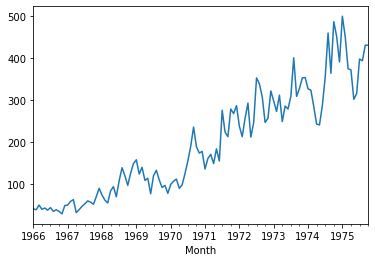

In [20]:
from matplotlib import pyplot
series.plot()
pyplot.show()

Observations: 
* There is an incresing trend in the data over time
* There is no outliers present
* fluctuations can be observed within the data year on year
* The data is not stationary

We can use differencing to make series stationary for modelling. We may need 2 level of differnencing if there is a growth teend in the fluctuation in later years. 

---------------------------------------------------------------------------------------------------
density plot
creates a histogram and density plot of the observations without any temporal structure.

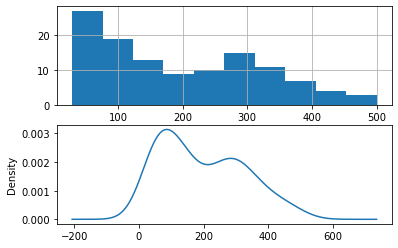

In [21]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind = 'kde')
pyplot.show()

* the distribution is not guassian
* it is left shufted, might be double guassian or exponential

------------------------------------------------------------------------------------------------
Box and whisker plots
grouping the observation by year and creates one box and whisker plot for each year of observation. 
(last year 1973 contains only 10 months, that we can ignore for comparison with other years)

In [22]:
from pandas import Grouper
groups = series['1966':'1973'].groupby(Grouper(freq ='A'))

In [23]:
print(series)

Month
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1975-06-01    316
1975-07-01    398
1975-08-01    394
1975-09-01    431
1975-10-01    431
Name: Robberies, Length: 118, dtype: int64


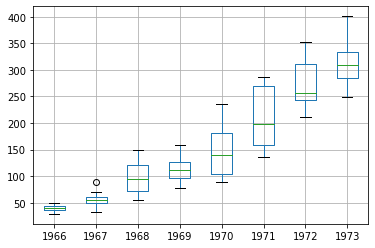

In [25]:
years = pd.DataFrame()
for name, group in groups: 
    years[name.year] = group.values
years.boxplot()
pyplot.show()

* Median values for each year are not showing a linear trend
* The 2nd quantile is not always lying in between the 1st and 3rd quantile. 
* the 1st 2 years are significantly different from rest of the years. 

----------------------------------------------------------------------------------------------------
**ARIMA model**
* Developing a manually configured ARIMA model
* Using agrid search of ARIMA to find optimized model
* Analysis of forecast residual errors to evaluate any bias in model
* Explore improvements to model using power transformers

-------------------------------------------------------------
Non seasonal ARIMA(p,d,q) requires 3 parametrs.
* Analysis of  time series assumes the data as stationary. 

**_But here we are working with non stationary data. Thus we need to make it stationary first by differencing the series and use statiscal test to confirm the result is stationary._**


In [27]:
from statsmodels.tsa.stattools import adfuller
from pandas import Series

#  create a differenced time series

def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i]-dataset[i-1]
        diff.append(value)
    return Series(diff)

In [22]:
X = series.values

# difference data
stationary = difference(X)
stationary.index = series.index[1:]

#  check if stationary
result = adfuller(stationary)

In [23]:
print('ADF statistics: ', result[0])
print('p-value: ', result[1])
print('Critical values:')

for key, value in result[4].items():
    print((key,value))
    
stationary.to_csv('stationary.csv', header=False)

ADF statistics:  -7.4285644750672075
p-value:  6.450795412686704e-11
Critical values:
('1%', -3.4936021509366793)
('5%', -2.8892174239808703)
('10%', -2.58153320754717)


**Dicker fuller test:**

test statistic value(-3.98) is smaller than the critical value at 5% of -2.893. This means we can reject the null hypothesis i.e. the data is not stationary (Ho). 
Hence, in turn, it is proved that the time series is stationary or does not have time dependent structure. 

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
 
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


*** This suggests that at least one level of differencing is required. The d parameter in our
ARIMA model should at least be a value of 1.

The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.


---------------------------------------------------------------------------------------------------------------------

**How to read ACF and PACF graphs to find p and q model?**

Auto regressive model is dependent on the previous values. To finf the order of the AR model, we refer to PACF. 

ACF and PACF assume stationarity of the underlying time series.. 



C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


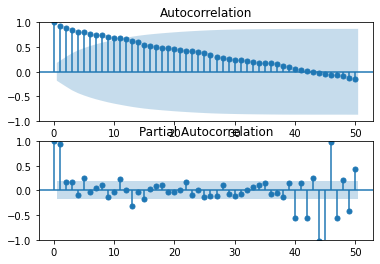

In [24]:

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=50, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=50, ax=pyplot.gca())
pyplot.show()

Blue area depicts the 95% confidence interval and is an indicator of the significance threshold. 

The ACF shows a significant lag for 10-11 months.(lags before entering into 95% CI)
The PACF shows a significant lag for perhaps 2 months.
Both the ACF and PACF show a drop off at the same point, perhaps suggesting a mix of AR and MA.

A good starting value of p and q values are 11 and 2

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

X = X.astype('float32')
train_size = int(len(X)*0.5)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order= (11,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    obs = test[i]
    history.append(obs)
    
    print('prediction=  ', yhat)
    print('Expected= ', obs)
    
    

C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   171.9323341661362
Expected=  178.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   195.3817437999469
Expected=  136.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   134.40584534567998
Expected=  161.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   174.24290307681468
Expected=  171.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   157.52415472305466
Expected=  149.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   138.65523480957205
Expected=  184.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   163.20098314407483
Expected=  155.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   154.80033674065248
Expected=  276.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   264.39327690808085
Expected=  224.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   221.9672775613812
Expected=  213.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


prediction=   227.00250350874796
Expected=  279.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   238.16112368319224
Expected=  268.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   263.214930028169
Expected=  287.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   270.3438852663386
Expected=  238.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   242.4585582115139
Expected=  213.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   258.2197716611503
Expected=  257.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   185.7482086597954
Expected=  293.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   303.3720106448832
Expected=  212.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   245.2319244913689
Expected=  246.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   249.12804554927442
Expected=  353.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   324.96427370614396
Expected=  339.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   307.66688525556435
Expected=  308.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   293.306507283885
Expected=  247.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   283.12652906229187
Expected=  257.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   303.50163149715354
Expected=  322.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   274.99788657526074
Expected=  298.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   265.996544924828
Expected=  273.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   302.7704451968857
Expected=  312.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   333.1293148197863
Expected=  249.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   255.23496013190737
Expected=  286.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   295.7161339754043
Expected=  279.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   294.8481135926019
Expected=  309.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   340.372624303826
Expected=  401.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   363.6898775959502
Expected=  309.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   284.6561282243431
Expected=  328.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   311.9456701108136
Expected=  353.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   311.4898487283676
Expected=  354.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   362.64417759417535
Expected=  327.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   317.2470552466696
Expected=  324.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   348.83337602238214
Expected=  285.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   331.74242834237356
Expected=  243.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   259.67972601937447
Expected=  241.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   246.82918556313106
Expected=  287.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   312.041234403335
Expected=  355.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   337.7943983350557
Expected=  460.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   412.8311924335385
Expected=  364.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   346.4597243557497
Expected=  487.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   447.39617341467886
Expected=  452.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   443.1818232101253
Expected=  391.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   408.734554307471
Expected=  500.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   419.75776413001967
Expected=  451.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   468.85892688805734
Expected=  375.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   384.0828837059498
Expected=  372.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   316.2092416575743
Expected=  302.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   352.77559544834867
Expected=  316.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   367.3883271796345
Expected=  398.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   365.93403219079187
Expected=  394.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction=   409.5548673068804
Expected=  431.0
prediction=   430.3410210537249
Expected=  431.0


C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(11,1,2) on raw data does not converge and results in errors. Thus the model is simplified to ARIMA(0,1,2)

In [26]:
X = X.astype('float32')
train_size = int(len(X)*0.5)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order= (0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    obs = test[i]
    history.append(obs)
    
    print('prediction=  ', yhat)
    print('Expected= ', obs)
    

prediction=   180.7052276380592
Expected=  178.0
prediction=   179.87256815291312
Expected=  136.0
prediction=   141.09782687717552
Expected=  161.0
prediction=   166.1726506918867
Expected=  171.0
prediction=   167.00513881486367
Expected=  149.0
prediction=   150.65649675838168
Expected=  184.0
prediction=   182.3143834336512
Expected=  155.0
prediction=   154.21307388911873
Expected=  276.0
prediction=   245.214227640463
Expected=  224.0
prediction=   225.90227330706395
Expected=  213.0
prediction=   216.8674629601438
Expected=  279.0
prediction=   258.69791490500205
Expected=  268.0
prediction=   263.3771917569708
Expected=  287.0
prediction=   279.94465627902645
Expected=  238.0
prediction=   251.48470742866664
Expected=  213.0
prediction=   226.5739171912907
Expected=  257.0
prediction=   249.6901441882708
Expected=  293.0
prediction=   277.21080638977077
Expected=  212.0
prediction=   230.02048900985767
Expected=  246.0
prediction=   245.78622529972623
Expected=  353.0
predictio

In [27]:
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE= ', rmse)

RMSE=  52.49442703824445


--------------------------------------------------------------------------

**Grid serach ARIMA hyperparameters**

Here, we will optimize the values of p, d, and q for combination that doesn't yield error in order to get the best performance of the model. 
p: 0 to 12
q: 0 to 3
d: 0 to 12

total 13*4*13 or 676 runs of test harness. 

In [ ]:
import warnings

def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size= int(len(X)*0.5)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    rmse = mean_squared_error(test, predictions)
    return rmse


def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values: 
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse<best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' %(order, rmse))                    
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
p_values = range(0,13)
d_values = range(0,4)
q_values = range(0,13)

warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=30724.709
ARIMA(0, 0, 1) RMSE=11495.777
ARIMA(0, 0, 2) RMSE=10785.106
ARIMA(0, 0, 3) RMSE=5829.999
ARIMA(0, 0, 4) RMSE=5425.617
ARIMA(0, 0, 5) RMSE=4746.197
ARIMA(0, 0, 6) RMSE=4523.559
ARIMA(0, 0, 7) RMSE=4178.011
ARIMA(0, 0, 8) RMSE=4688.077
ARIMA(0, 0, 9) RMSE=3585.927
ARIMA(0, 0, 10) RMSE=4276.526
ARIMA(0, 0, 11) RMSE=4498.779
ARIMA(0, 0, 12) RMSE=3992.096
ARIMA(0, 1, 0) RMSE=2936.695
ARIMA(0, 1, 1) RMSE=2742.040
ARIMA(0, 1, 2) RMSE=2755.665
ARIMA(0, 1, 3) RMSE=2886.975
ARIMA(0, 1, 4) RMSE=2749.742
ARIMA(0, 1, 5) RMSE=2893.586
ARIMA(0, 1, 6) RMSE=3030.045
ARIMA(0, 1, 7) RMSE=2981.040
ARIMA(0, 1, 8) RMSE=3050.815
ARIMA(0, 1, 9) RMSE=3201.032
ARIMA(0, 1, 10) RMSE=3437.773
ARIMA(0, 1, 11) RMSE=3050.318
ARIMA(0, 1, 12) RMSE=2902.960
ARIMA(0, 2, 0) RMSE=7523.949
ARIMA(0, 2, 1) RMSE=2953.557
ARIMA(0, 2, 2) RMSE=2749.055
ARIMA(0, 2, 3) RMSE=2690.657
ARIMA(0, 2, 4) RMSE=2872.013
ARIMA(0, 2, 5) RMSE=2587.291
ARIMA(0, 2, 6) RMSE=2744.357
ARIMA(0, 2, 7) RMSE=2845.840
ARIMA

 **Review residual errors**
 
 Ideally, the distribution of residual errors should be guassian with a zero mean. To check this, we wil plot histogram and density plots. 

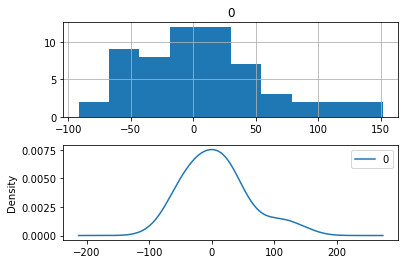

In [28]:
# moedl
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(0,1,2))

    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)

#  residual error plot
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pandas.DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

The graph is guassian like distribution with longer right tail. This is due the bias in prediction. To avoid this, using power based transformers would be useful. 

* We should check the autocorrelation of residual errors, it would suggest if model has more opportunity to model the temporal structural in data. 
For this again we will plot ACF & PACF

C:\Users\kajal\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


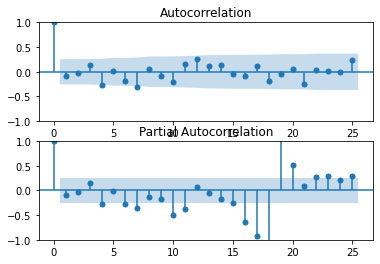

In [29]:
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pandas.DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca())
pyplot.show()

the result shows that the little autocorrelation is present in the dataset. 

------------------------------------------------------------------------------
**Box Cox transformation**

This method is able to evaluate a suite of power transforms including, but not limited to, log, square root, and reciprocal transforms of the data. 

C:\Users\kajal\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


lambda: 0.316715


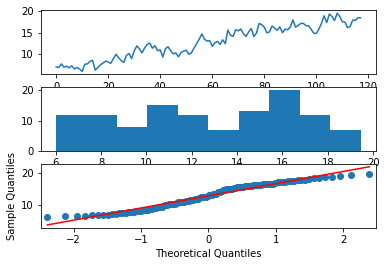

In [30]:
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot

transformed, lam = boxcox(X)
print('lambda: %f' % lam)
pyplot.figure(1)

pyplot.subplot(311)
pyplot.plot(transformed)

pyplot.subplot(312)
pyplot.hist(transformed)

pyplot.subplot(313)
qqplot(transformed, line ='r', ax = pyplot.gca())
pyplot.show()

1st graph: Line chart of the transformed model

2nd graph: histogram of transformed values

3rd: Q-Q plot showing how the distribution of values compared to an idealized guassian distribution. 


After box-cox transformation:
* large fluctuation has been removed
* histogram shows a flatter or more uniform distribution of values
* plot is reasonable but not a perfect guassian distribution

----------------------------------------------------------------------------------------------
Before proceeding to test the ARIMA model with the transformed data, we must have
a way to reverse the transform in order to convert predictions made with a model trained on
the transformed data back into the original scale.

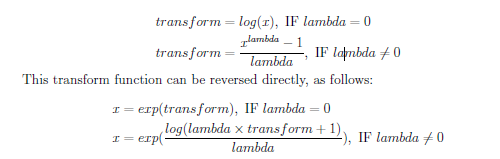

In [31]:
#  invert box-cox

from math import log
from math import exp

def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value +1) / lam)

In [38]:
#  re-evaluate the ARIMA(0,1,2) 
#  1st transform the data prior to fitting the model and then inverting the tranformation on the prediction before storing
#  sometimes, the box-cox failed and gives the transformation lambda value < -5. Thus,, by convention lambda values rae evaluated between -5 to 5
#  thus if -5 < lam < 5, them lam =1 to be considered. Am lam =1 has no effect on the transformation. 

X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()

for i in range(len(test)):
    transformed, lam = boxcox(history)
    if lam< -5:
        transformed, lam = history, 1
    model = ARIMA(transformed, order = (0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # inverse boxcox
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    
    #observation
    obs=test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE= %.3f' % rmse)
    
    

>Predicted=178.196, Expected=178.000
>Predicted=179.316, Expected=136.000
>Predicted=145.460, Expected=161.000
>Predicted=165.568, Expected=171.000
>Predicted=166.483, Expected=149.000
>Predicted=152.065, Expected=184.000
>Predicted=179.561, Expected=155.000
>Predicted=155.211, Expected=276.000
>Predicted=238.977, Expected=224.000
>Predicted=210.753, Expected=213.000
>Predicted=214.075, Expected=279.000
>Predicted=257.447, Expected=268.000
>Predicted=255.413, Expected=287.000


C:\Users\kajal\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\kajal\Anaconda3\lib\site-packages\numpy\core\_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


>Predicted=275.941, Expected=238.000
>Predicted=245.091, Expected=213.000
>Predicted=226.699, Expected=257.000
>Predicted=252.344, Expected=293.000
>Predicted=275.302, Expected=212.000
>Predicted=224.656, Expected=246.000
>Predicted=248.227, Expected=353.000
>Predicted=313.577, Expected=339.000
>Predicted=312.855, Expected=308.000
>Predicted=305.388, Expected=247.000
>Predicted=263.453, Expected=257.000
>Predicted=268.874, Expected=322.000
>Predicted=307.069, Expected=298.000
>Predicted=290.762, Expected=273.000
>Predicted=279.628, Expected=312.000
>Predicted=305.832, Expected=249.000
>Predicted=259.479, Expected=286.000
>Predicted=288.086, Expected=279.000
>Predicted=277.060, Expected=309.000
>Predicted=300.444, Expected=401.000
>Predicted=361.789, Expected=309.000
>Predicted=307.486, Expected=328.000
>Predicted=330.341, Expected=353.000
>Predicted=342.084, Expected=354.000
>Predicted=346.257, Expected=327.000
>Predicted=330.891, Expected=324.000
>Predicted=329.470, Expected=285.000
>

Final step: 
1. Finalize the model
2. Make prediction
3. Vaidate model

In [48]:
# finalize model and save to file with workaround
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import numpy
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# load data
series = read_csv(r'dataset.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')

# transform data
transformed, lam = boxcox(X)

# fit model
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit()

# save model
model_fit.save('model.pkl')
numpy.save('model_lambda.npy', [lam])

* model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coeffcients and all other internal data returned when fitting the model.

* model lambda.npy This is the lambda value stored as a one-row, one-column NumPy array.

In [49]:
# load the finalized model and make a prediction
from statsmodels.tsa.arima.model import ARIMAResults
from math import exp
from math import log
import numpy
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print('Predicted: %.3f' % yhat)

Predicted: 452.580


we saved the final 12 months of the original dataset in a separate file to validate the final model.

>Predicted=452.580, Expected=452.000
>Predicted=429.900, Expected=391.000
>Predicted=401.393, Expected=500.000
>Predicted=476.461, Expected=451.000
>Predicted=442.454, Expected=375.000
>Predicted=397.525, Expected=372.000
>Predicted=390.647, Expected=302.000
>Predicted=329.393, Expected=316.000
>Predicted=334.171, Expected=398.000
>Predicted=382.819, Expected=394.000
>Predicted=378.508, Expected=431.000
>Predicted=413.525, Expected=431.000
RMSE: 51.949


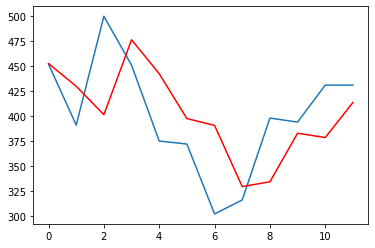

In [53]:
# evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log
import numpy
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')

# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
# transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()